# Importar principales librerías de Python

In [1]:
# Librerías estándar
import numpy  as np
import pandas as pd

import itertools
import random

# Gráficas
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline  
import seaborn as sns
sns.set(style="white")

# scikit-learn
from sklearn.dummy           import DummyClassifier
from sklearn.linear_model    import LogisticRegression
from sklearn.linear_model    import LinearRegression
from sklearn.linear_model    import Lasso
from sklearn.metrics         import confusion_matrix
from sklearn.metrics         import roc_curve
from sklearn.metrics         import roc_auc_score
from sklearn.preprocessing   import StandardScaler
from sklearn.model_selection import train_test_split


# Ignorar warnings 
import warnings
warnings.filterwarnings('ignore')

# Para poder replicar los resultados de problemas aleatorios, es necesario definir una semilla
SEED = 1

# Definición de algunas funciones que nos ayudaran más adelante

In [2]:
def grafica_matriz_confusion(cm, classes=[0,1], normalize=False, title='Matriz de confusión\n', cmap=plt.cm.Reds):
    """ 
    Función para mostrar la matriz de confusión de un problema de clasificación binario. 
    El parámetro cm puede ser el objeto resultante de ejecutar la función confusion_matrix() de la librería sklearn.
    
    Args:
        cm         matriz de confusión de sklearn
        classes    categorías de la variable target
        normalize  normaliza asignando el parámetro True
        title      string para definir el título para la gráfica
        cmap       mapa de colores
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    thresh = cm.max()
    text = [["VN =", "FN ="], ["FP =", "VP ="]]
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, "     {}".format(round (cm[i, j],2)), horizontalalignment="left",
                 color="white" if cm[i, j] > thresh else "black")
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, text[j][i] , horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('Valor real')
    plt.xlabel('Predicción')
    
def grafica_curva_roc(fpr, tpr, title='Curva ROC', note=''):
    """
    Función para graficar la curva ROC
    Los parámetros fpr y tpr son el output de ejecutar la función roc_curve de sklearn
    
    Args:
        fpr        Tasa de falsos positivos 
        tpr        Tasa de verdaderos positivos
        title      sting para definir el título de la gráfica
        note       Nota para mostrar en la gráfica
    """
    plt.figure(1)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr)
    plt.xlabel('Tasa de falsos positivos ')
    plt.ylabel('Tasa de verdaderos positivos')
    plt.title(title)
    if note: plt.text(0.6, 0.2, note)
    plt.show()
    
def histograma(data, color, xlabel):
    """ 
    Función para graficar un histograma
    
    Args:
        data       pandas dataframe
        color      string para definir el color de las barras del histograma
        xlabel     Etiqueta para el axis de las ys
    """
    ax = sns.distplot(data, kde=False, bins=10, color=color, hist_kws={"linewidth": 15,'alpha':0.3})
    ax.set(xlabel=xlabel, ylabel='Frecuencia')

# Importar los datos

In [3]:
# Importar datos
data = pd.read_csv('data/credit_data.csv')

In [4]:
# Ver el nombre de todas las variables independientes
print('\n'.join(data.columns))

ID
LIMIT_BAL
SEX
EDUCATION
MARRIAGE
AGE
PAY_1
PAY_2
PAY_3
PAY_4
PAY_5
PAY_6
BILL_AMT1
BILL_AMT2
BILL_AMT3
BILL_AMT4
BILL_AMT5
BILL_AMT6
PAY_AMT1
PAY_AMT2
PAY_AMT3
PAY_AMT4
PAY_AMT5
PAY_AMT6
customer_default


In [5]:
# Checar el tipo de dato de cada variable
data.dtypes

ID                  int64
LIMIT_BAL           int64
SEX                 int64
EDUCATION           int64
MARRIAGE            int64
AGE                 int64
PAY_1               int64
PAY_2               int64
PAY_3               int64
PAY_4               int64
PAY_5               int64
PAY_6               int64
BILL_AMT1           int64
BILL_AMT2           int64
BILL_AMT3           int64
BILL_AMT4           int64
BILL_AMT5           int64
BILL_AMT6           int64
PAY_AMT1            int64
PAY_AMT2            int64
PAY_AMT3            int64
PAY_AMT4            int64
PAY_AMT5            int64
PAY_AMT6            int64
customer_default    int64
dtype: object

# Exploración de Datos

In [6]:
# Explora la variable "EDUCATION"
data['EDUCATION'].value_counts()

2    14030
1    10585
3     4917
5      280
4      123
6       51
0       14
Name: EDUCATION, dtype: int64

In [7]:
# Explora la variable "customer_default"
data['customer_default'].value_counts()

0    23364
1     6636
Name: customer_default, dtype: int64

In [8]:
# Explora la distribución de la variable "customer_default"
data['customer_default'].value_counts()/data.shape[0]

0    0.7788
1    0.2212
Name: customer_default, dtype: float64

### ¿Está balanceada esta variable target?

In [9]:
# Explora la variable "SEX" por valores de la variable que indica si un cliente hace default o no
ct = pd.crosstab(data.SEX, data.customer_default)
ct['Total'] = ct[0] + ct[1]
ct

customer_default,0,1,Total
SEX,,,
1,9015,2873,11888
2,14349,3763,18112


In [10]:
# Explora la variable "MARRIAGE" por valores de la variable que indica si un cliente hace default o no
ct = pd.crosstab(data.MARRIAGE, data.customer_default)
ct['Total'] = ct[0] + ct[1]
ct

customer_default,0,1,Total
MARRIAGE,,,
0,49,5,54
1,10453,3206,13659
2,12623,3341,15964
3,239,84,323


In [11]:
# Checar el monto mínimo de límite de crédito en la variable "LIMIT_BAL"
np.min(data.LIMIT_BAL)

10000

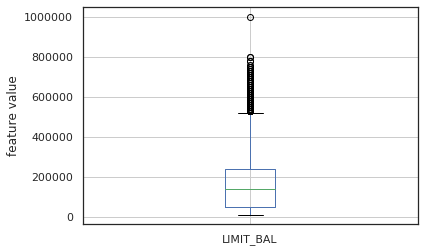

In [12]:
# Checar la distribución de la variable "LIMIT_BAL" (límite de crédito)
data.boxplot(column='LIMIT_BAL')
plt.ylabel('feature value')
plt.show()

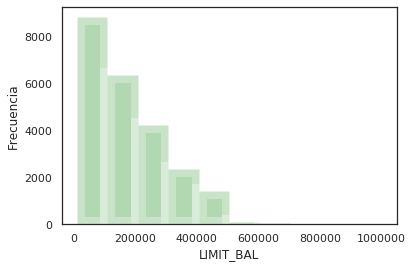

In [13]:
# Grafica un histograma de la variable "LIMIT_BAL" de los clientes que no hicieron default
histograma(data["LIMIT_BAL"][data["customer_default"] == 0], xlabel='LIMIT_BAL', color='green')

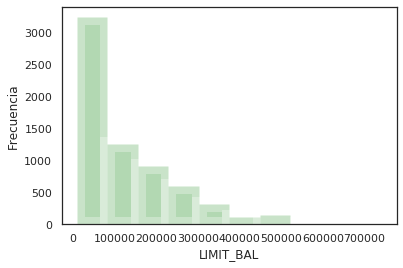

In [14]:
# Grafica un histograma de la variable "LIMIT_BAL" de los clientes que sí hicieron default
histograma(data["LIMIT_BAL"][data["customer_default"] == 1], xlabel='LIMIT_BAL', color='green')

# Transformación de datos

In [15]:
# Crear variables dummy para las variables categóricas "SEX" y "MARRIAGE"
data = pd.get_dummies(data=data, columns=['SEX', 'MARRIAGE'])

In [16]:
# Mostrar el nombre de las variables dummy creadas
print('\n'.join(data.columns))

ID
LIMIT_BAL
EDUCATION
AGE
PAY_1
PAY_2
PAY_3
PAY_4
PAY_5
PAY_6
BILL_AMT1
BILL_AMT2
BILL_AMT3
BILL_AMT4
BILL_AMT5
BILL_AMT6
PAY_AMT1
PAY_AMT2
PAY_AMT3
PAY_AMT4
PAY_AMT5
PAY_AMT6
customer_default
SEX_1
SEX_2
MARRIAGE_0
MARRIAGE_1
MARRIAGE_2
MARRIAGE_3


In [17]:
# Explora la categoría 0
data['MARRIAGE_0'].value_counts() 

0    29946
1       54
Name: MARRIAGE_0, dtype: int64

In [18]:
# Explora la categoría 1
data['MARRIAGE_1'].value_counts() 

0    16341
1    13659
Name: MARRIAGE_1, dtype: int64

In [19]:
# Explora la categoría 2
data['MARRIAGE_2'].value_counts() 

1    15964
0    14036
Name: MARRIAGE_2, dtype: int64

In [20]:
# Explora la categoría 3
data['MARRIAGE_3'].value_counts() 

0    29677
1      323
Name: MARRIAGE_3, dtype: int64

# Métricas de ajuste para un problema de clasificación binario

In [21]:
# Define la variable target (Cliente con default en el siguiente mes)
y = np.array(data['customer_default'])

# Define el conjunto de variables independientes
atributos = list(set(list(data.columns)) - set(['customer_default']))
X = data.loc[:, atributos]

In [22]:
# Divide el set de entrenamiento en dos sets (entrenamiento y validación) con la función train_test_split() de sklearn. Utiliza 20% para el set de validación
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1, stratify=y)

## Métricas para un clasificador que predice al azar

In [23]:
# Haz una predicción al azar. Recuerda que nuestras etiquetas son {0= no default, 1= default}
y_pred_azar = [random.choice([0, 1]) for v in y_test]

In [24]:
# Distribución de predicciones utilizando un clasificador al azar
pd.Series(y_pred_azar).value_counts()/len(y_pred_azar)

0    0.500333
1    0.499667
dtype: float64

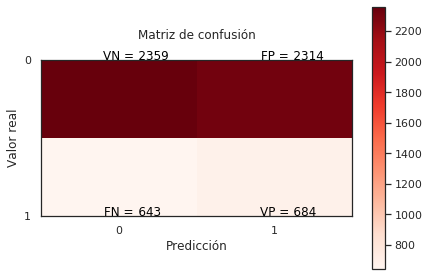

In [25]:
# Muestra la matriz de confusión para el clasificador que predice el azar
matriz_confusion_azar = confusion_matrix(y_test, y_pred_azar)  
grafica_matriz_confusion(matriz_confusion_azar)

In [26]:
# Cuántos errores cometimos?
error_azar = matriz_confusion_azar[0][1] + matriz_confusion_azar[1][0]
print('# Errores =', error_azar)
print('% Erroress =', error_azar/len(y_pred_azar))

# Errores = 2957
% Erroress = 0.49283333333333335


In [27]:
# Calcula la efectividad
efectividad_azar = matriz_confusion_azar[0][0] + matriz_confusion_azar[1][1]
print('# Aciertos =', efectividad_azar)
print('% Efectividad =', efectividad_azar/len(y_pred_azar))
print('Otra forma de calcular la efectividad =', 1-(error_azar/len(y_pred_azar)))

# Aciertos = 3043
% Efectividad = 0.5071666666666667
Otra forma de calcular la efectividad = 0.5071666666666667


In [28]:
# Calcula el recall y la precisión de la predicción
print('% Recall =', matriz_confusion_azar[1][1]/(matriz_confusion_azar[1][1] + matriz_confusion_azar[1][0]))
print('% Precisión =', matriz_confusion_azar[1][1]/(matriz_confusion_azar[1][1] + matriz_confusion_azar[0][1]))

% Recall = 0.5154483798040693
% Precisión = 0.22815210140093395


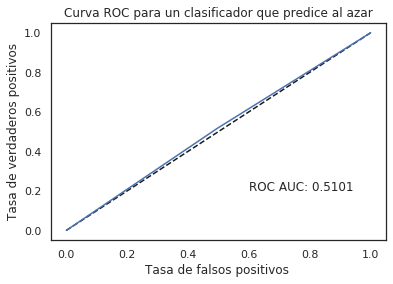

In [29]:
# Calcula la tasa de falsos positivos y la tasa de verdaderos positivos para poder graficar la curva ROC, y para calcular la métrica ROC AUC
fpr_azar, tpr_azar, _ = roc_curve(y_test, y_pred_azar)
auc_azar = roc_auc_score(y_test, y_pred_azar)
grafica_curva_roc(fpr_azar, tpr_azar, 'Curva ROC para un clasificador que predice al azar', note='ROC AUC: {0:.4f}'.format(auc_azar))

## Métricas para un clasificador que siempre predice la categoría más frecuente en la variable target

In [30]:
# Determina el valor más frecuente para la variable target "customer_default"
valor_mas_frecuente = data['customer_default'].value_counts().idxmax()
print('Valor más frecuente =', valor_mas_frecuente)

Valor más frecuente = 0


In [31]:
# Haz una predicción utilizando el valor más frecuente. Recuerda que nuestras etiquetas son {0= no default, 1= default}
y_pred_mas_frecuente = [valor_mas_frecuente for v in y_test]
pd.Series(y_pred_mas_frecuente).value_counts()

0    6000
dtype: int64

In [32]:
# Distribución de predicciones utilizando el valor más frecuente de la target
pd.Series(y_pred_mas_frecuente).value_counts()/len(y_pred_mas_frecuente)

0    1.0
dtype: float64

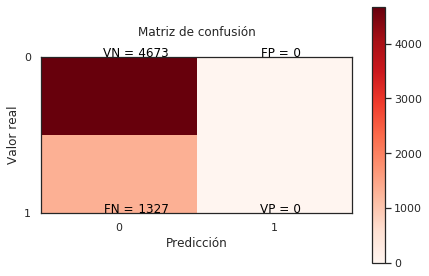

In [33]:
# Muestra la matriz de confusión para el clasificador que predice siempre el valor más frecuente
matriz_confusion_mas_frecuente = confusion_matrix(y_test, y_pred_mas_frecuente)  
grafica_matriz_confusion(matriz_confusion_mas_frecuente)

In [34]:
# Cuántos errores cometimos?
error_mas_frecuente = matriz_confusion_mas_frecuente[0][1] + matriz_confusion_mas_frecuente[1][0]
print('# Errores =', error_mas_frecuente)
print('% Erroress =', error_mas_frecuente/len(y_pred_mas_frecuente))

# Errores = 1327
% Erroress = 0.22116666666666668


In [35]:
# Calcula la efectividad
efectividad_mas_frecuente = matriz_confusion_mas_frecuente[0][0] + matriz_confusion_mas_frecuente[1][1]
print('# Aciertos =', efectividad_mas_frecuente)
print('% Efectividad =', efectividad_mas_frecuente/len(y_pred_mas_frecuente))
print('Otra forma de calcular la efectividad =', 1-(error_mas_frecuente/len(y_pred_mas_frecuente)))

# Aciertos = 4673
% Efectividad = 0.7788333333333334
Otra forma de calcular la efectividad = 0.7788333333333333


In [36]:
# Calcula el recall y la precisión de la predicción
print('% Recall =', matriz_confusion_mas_frecuente[1][1]/(matriz_confusion_mas_frecuente[1][1] + matriz_confusion_mas_frecuente[1][0]))
print('% Precisión =', matriz_confusion_mas_frecuente[1][1]/(matriz_confusion_mas_frecuente[1][1] + matriz_confusion_mas_frecuente[0][1]))

% Recall = 0.0
% Precisión = nan


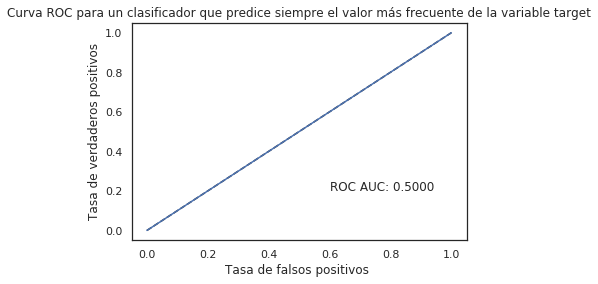

In [37]:
# Calcula la tasa de falsos positivos y la tasa de verdaderos positivos para poder graficar la curva ROC, y para calcular la métrica ROC AUC
fpr_mas_frecuente, tpr_mas_frecuente, _ = roc_curve(y_test, y_pred_mas_frecuente)
auc_mas_frecuente = roc_auc_score(y_test, y_pred_mas_frecuente)
grafica_curva_roc(fpr_mas_frecuente, tpr_mas_frecuente, 'Curva ROC para un clasificador que predice siempre el valor más frecuente de la variable target', note='ROC AUC: {0:.4f}'.format(auc_mas_frecuente))

### <(°o°)> ¿Cómo es posible que predecir el valor más frecuente de 77.8% de efectividad?

## Métricas para un modelo de regresión lineal con un parámetro de 30% como punto de corte para la "probabilidad"

In [38]:
# Entrena una regresión lineal para predecir si un cliente hará default
modelo_LinReg = LinearRegression()
modelo_LinReg.fit(X_train, y_train)
y_pred_proba_LinReg = modelo_LinReg.predict(X_test)  # Predice la "probabilidad"

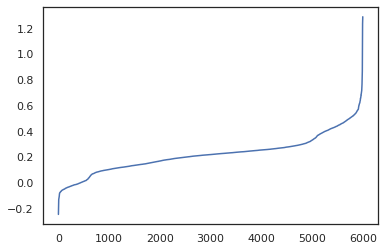

In [39]:
# Grafica los resultados 
plt.plot(sorted(y_pred_proba_LinReg))

### Hay algo que no hace sentido... ¿Qué es?

In [40]:
# Haz una predicción con base en un parámetro para la "probabilidad" del modelo de regresión lineal. Recuerda que nuestras etiquetas son {0= no default, 1= default}
threshold = 0.30
y_pred_LinReg = [int(v >= threshold) for v in y_pred_proba_LinReg]
pd.Series(y_pred_LinReg).value_counts()

0    4822
1    1178
dtype: int64

In [41]:
# Distribución de predicciones
pd.Series(y_pred_LinReg).value_counts()/len(y_pred_LinReg)

0    0.803667
1    0.196333
dtype: float64

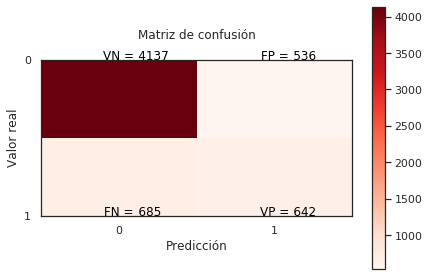

In [42]:
# Muestra la matriz de confusión
matriz_confusion_LinReg = confusion_matrix(y_test, y_pred_LinReg)  
grafica_matriz_confusion(matriz_confusion_LinReg)

In [43]:
# Cuántos errores cometimos?
error_LinReg = matriz_confusion_LinReg[0][1] + matriz_confusion_LinReg[1][0]
print('# Errores =', error_LinReg)
print('% Erroress =', error_LinReg/len(y_pred_LinReg))

# Errores = 1221
% Erroress = 0.2035


In [44]:
# Calcula la efectividad
efectividad_LinReg = matriz_confusion_LinReg[0][0] + matriz_confusion_LinReg[1][1]
print('# Aciertos =', efectividad_LinReg)
print('% Efectividad =', efectividad_LinReg/len(y_pred_LinReg))
print('Otra forma de calcular la efectividad =', 1-(error_LinReg/len(y_pred_LinReg)))

# Aciertos = 4779
% Efectividad = 0.7965
Otra forma de calcular la efectividad = 0.7965


In [45]:
# Calcula el recall y la precisión de la predicción
print('% Recall =', matriz_confusion_LinReg[1][1]/(matriz_confusion_LinReg[1][1] + matriz_confusion_LinReg[1][0]))
print('% Precisión =', matriz_confusion_LinReg[1][1]/(matriz_confusion_LinReg[1][1] + matriz_confusion_LinReg[0][1]))

% Recall = 0.48379804069329313
% Precisión = 0.5449915110356537


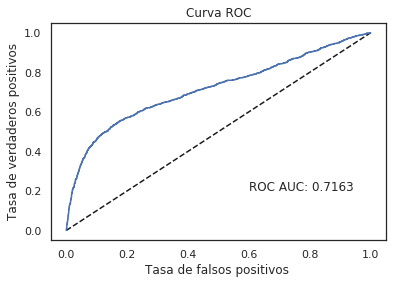

In [46]:
# Calcula la tasa de falsos positivos y la tasa de verdaderos positivos para poder graficar la curva ROC, y para calcular la métrica ROC AUC
fpr_LinReg, tpr_LinReg, _ = roc_curve(y_test, y_pred_proba_LinReg)
auc_LinReg = roc_auc_score(y_test, y_pred_proba_LinReg)
grafica_curva_roc(fpr_LinReg, tpr_LinReg, 'Curva ROC', note='ROC AUC: {0:.4f}'.format(auc_LinReg))

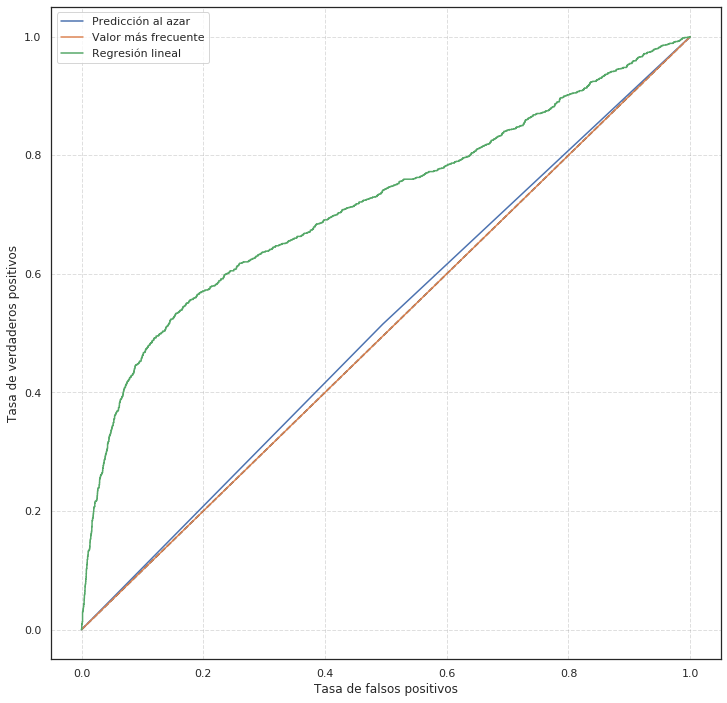

In [47]:
# Grafica para comparar curvas ROC
fig, ax1 = plt.subplots(1, 1)
fig.set_size_inches(12,12)
ax1.xaxis.grid(True, linestyle='--', which='major', color='grey', alpha=.25)
ax1.yaxis.grid(True, linestyle='--', which='major', color='grey', alpha=.25)
plt.plot([0, 1], [0, 1], 'k--')

plt.plot(fpr_azar, tpr_azar, label='Predicción al azar')
plt.plot(fpr_mas_frecuente, tpr_mas_frecuente, label='Valor más frecuente')
plt.plot(fpr_LinReg, tpr_LinReg, label='Regresión lineal')

plt.xlabel('Tasa de falsos positivos')
plt.ylabel('Tasa de verdaderos positivos')
plt.legend()
ax1.legend=True
plt.show()